# HP-MOCD

## Comprehensive Implementation & Comparison

### A HIGH-PERFORMANCE EVOLUTIONARY MULTIOBJECTIVE COMMUNITY DETECTION ALGORITHM
This notebook provides a **clean, systematic analysis** of [HP-MOCD](https://arxiv.org/pdf/2506.01752) community detection on citation networks using the **NQ (Natural Questions) dataset**.

## 1. Setup & Imports

In [16]:
# Core libraries
import ast
import time
import json
from collections import Counter, defaultdict

# Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Graph analysis
import networkx as nx
from pymocd import HpMocd 

## 2. Data Loading & Graph Preparation

In [17]:
def load_nq_citation_data():
    """Load NQ dataset and create directed citation graph."""
    print("📊 Loading NQ citation dataset...")
    
    # Load data
    df = pd.read_csv("../data/v0.0/df_nq_version0.csv")
    print(f"   Loaded {len(df):,} papers")
    
    # Parse citations
    df["cites_ids"] = df["cites_ids"].apply(ast.literal_eval)
    
    # Create directed citation graph
    G_directed = nx.DiGraph()
    
    # Add nodes with metadata
    for _, row in df.iterrows():
        G_directed.add_node(row["id"], title=row["d_properties_document_title"])
    
    # Add citation edges (source cites target)
    citation_count = 0
    for _, row in df.iterrows():
        for target in row["cites_ids"]:
            if target in G_directed:  # Only add if target exists in our dataset
                G_directed.add_edge(row["id"], target)
                citation_count += 1
    
    print(f"   Created directed graph: {G_directed.number_of_nodes():,} nodes, {G_directed.number_of_edges():,} edges")
    print(f"   Average citations per paper: {citation_count/len(df):.1f}")
    
    return G_directed, df

# Load the citation data
G_directed, df = load_nq_citation_data()

📊 Loading NQ citation dataset...
   Loaded 108,071 papers


KeyboardInterrupt: 

In [ ]:
def prepare_citation_graphs(G_directed):
    """Prepare both directed and weighted undirected graphs for analysis."""
    print("🔧 Preparing graphs for Leiden analysis...")
    
    # Clean directed graph
    print("\n--- Directed Graph Preparation ---")
    isolated = [n for n, d in G_directed.degree() if d == 0]
    if isolated:
        G_directed.remove_nodes_from(isolated)
        print(f"   Removed {len(isolated):,} isolated nodes")
    
    # Get largest weakly connected component
    if not nx.is_weakly_connected(G_directed):
        largest_wcc = max(nx.weakly_connected_components(G_directed), key=len)
        G_directed = G_directed.subgraph(largest_wcc).copy()
        print(f"   Using largest weakly connected component: {G_directed.number_of_nodes():,} nodes")
    
    print(f"   ✅ Final directed graph: {G_directed.number_of_nodes():,} nodes, {G_directed.number_of_edges():,} edges")
    
    # Create weighted undirected graph
    print("\n--- Weighted Undirected Graph Creation ---")
    G_weighted = nx.Graph()
    
    # Add edges with weights (count bidirectional citations)
    for u, v in G_directed.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1  # Bidirectional citation
        else:
            G_weighted.add_edge(u, v, weight=1)  # Unidirectional citation
    
    # Analyze weight distribution
    weights = [d['weight'] for u, v, d in G_weighted.edges(data=True)]
    weight_dist = Counter(weights)
    bidirectional = sum(1 for w in weights if w > 1)
    
    print(f"   ✅ Weighted undirected graph: {G_weighted.number_of_nodes():,} nodes, {G_weighted.number_of_edges():,} edges")
    print(f"   Weight distribution: {dict(sorted(weight_dist.items()))}... (showing first 5)")
    print(f"   Bidirectional citations: {bidirectional:,} edges ({bidirectional/len(weights)*100:.1f}%)")
    
    return G_directed, G_weighted

# Prepare both graph types
G_directed, G_weighted = prepare_citation_graphs(G_directed)

print(f"\n🎯 Ready for analysis:")
print(f"   Directed: {G_directed.number_of_nodes():,} nodes, {G_directed.number_of_edges():,} edges")
print(f"   Weighted: {G_weighted.number_of_nodes():,} nodes, {G_weighted.number_of_edges():,} edges")

🔧 Preparing directed graph for Infomap analysis...

--- Graph Cleaning ---
   Removed 535 isolated nodes
   Using largest weakly connected component: 107,534 nodes
   ✅ Final directed graph: 107,534 nodes, 5,122,982 edges
   In-degree statistics: min=0, max=46388, avg=47.6
   Out-degree statistics: min=0, max=1394, avg=47.6

🎯 Ready for Infomap analysis: 107,534 nodes, 5,122,982 edges
   Using largest weakly connected component: 107,534 nodes
   ✅ Final directed graph: 107,534 nodes, 5,122,982 edges
   In-degree statistics: min=0, max=46388, avg=47.6
   Out-degree statistics: min=0, max=1394, avg=47.6

🎯 Ready for Infomap analysis: 107,534 nodes, 5,122,982 edges


## HP MOCD

In [18]:
def create_test_graph():
    """Create different types of test graphs to demonstrate reporting."""

    citation_graph = nx.barabasi_albert_graph(200, 3, seed=42)
    # Convert to directed and add some realistic citation patterns
    citation_graph = citation_graph.to_directed()

    # Add some node metadata to simulate papers
    for i, node in enumerate(citation_graph.nodes()):
        citation_graph.nodes[node]['title'] = f"Paper_{i:03d}"
        citation_graph.nodes[node]['year'] = 2020 + \
            (i % 5)  # Papers from 2020-2024

    # Remove some edges to make it more citation-like (younger papers don't cite older ones)
    edges_to_remove = []
    for u, v in citation_graph.edges():
        u_year = citation_graph.nodes[u].get('year', 2020)
        v_year = citation_graph.nodes[v].get('year', 2020)
        if u_year < v_year:  # Remove "backwards" citations
            edges_to_remove.append((u, v))

    citation_graph.remove_edges_from(edges_to_remove)

    citation_info = {
        "source": "Simulated Citation Network",
        "description": "Directed graph simulating academic paper citations",
        "parameters": {"n": 200, "temporal_structure": True}
    }

    return citation_graph, citation_info

# Create a test citation graph
G_test, citation_info = create_test_graph()

In [19]:
alg = HpMocd(
    graph=G_test,
    debug_level=1,
    pop_size=100,
    num_gens=100,
    cross_rate=0.8,
    mut_rate=0.2
)

solution = alg.run()
print(solution)

{0: 0, 88: 1, 151: 2, 25: 3, 176: 3, 113: 4, 50: 3, 138: 5, 75: 5, 12: 6, 163: 4, 100: 7, 188: 9, 37: 8, 125: 10, 62: 3, 150: 6, 87: 11, 24: 12, 175: 3, 112: 13, 49: 0, 137: 0, 74: 4, 11: 7, 162: 11, 99: 7, 36: 14, 187: 0, 124: 4, 61: 15, 149: 16, 86: 5, 23: 2, 174: 17, 111: 18, 48: 16, 199: 0, 136: 14, 73: 2, 10: 19, 161: 20, 98: 6, 35: 1, 186: 2, 123: 17, 60: 19, 148: 6, 85: 2, 22: 6, 173: 21, 110: 11, 47: 6, 198: 5, 135: 2, 72: 4, 9: 4, 160: 7, 97: 10, 34: 22, 185: 0, 122: 6, 59: 16, 147: 14, 84: 4, 21: 4, 172: 10, 109: 19, 46: 7, 197: 4, 134: 8, 71: 18, 8: 1, 159: 23, 96: 17, 33: 2, 184: 24, 121: 15, 58: 1, 146: 14, 83: 1, 20: 2, 171: 7, 108: 8, 45: 3, 196: 20, 133: 1, 70: 17, 7: 11, 158: 3, 95: 0, 32: 17, 183: 2, 120: 0, 57: 7, 145: 2, 82: 11, 19: 5, 170: 0, 107: 7, 44: 25, 195: 11, 132: 11, 69: 4, 6: 7, 157: 16, 94: 0, 31: 17, 182: 13, 119: 5, 56: 18, 144: 22, 81: 7, 18: 9, 169: 7, 106: 15, 43: 0, 194: 4, 131: 4, 68: 6, 5: 2, 156: 1, 93: 6, 30: 4, 181: 15, 118: 7, 55: 4, 143: 7, 

In [20]:
frontier = alg.generate_pareto_front()

labels, (intra_score, inter_score) = frontier[23]

print("Node → Community:", labels)
print(f"Inter: {intra_score:.4f}, Intra: {inter_score:.4f}")

Node → Community: {0: 0, 88: 1, 151: 2, 25: 3, 176: 3, 113: 4, 50: 3, 138: 5, 75: 5, 12: 6, 163: 7, 100: 8, 188: 5, 37: 9, 125: 10, 62: 3, 150: 11, 87: 12, 24: 13, 175: 3, 112: 14, 49: 0, 137: 0, 74: 4, 11: 8, 162: 12, 99: 15, 36: 16, 187: 0, 124: 4, 61: 17, 149: 18, 86: 5, 23: 19, 174: 20, 111: 21, 48: 18, 199: 0, 136: 16, 73: 21, 10: 22, 161: 23, 98: 24, 35: 1, 186: 25, 123: 20, 60: 22, 148: 24, 85: 2, 22: 9, 173: 26, 110: 12, 47: 6, 198: 5, 135: 21, 72: 4, 9: 7, 160: 27, 97: 10, 34: 28, 185: 29, 122: 9, 59: 30, 147: 16, 84: 4, 21: 0, 172: 10, 109: 22, 46: 31, 197: 4, 134: 32, 71: 33, 8: 1, 159: 34, 96: 35, 33: 36, 184: 37, 121: 38, 58: 1, 146: 16, 83: 1, 20: 39, 171: 27, 108: 40, 45: 3, 196: 23, 133: 1, 70: 41, 7: 12, 158: 3, 95: 29, 32: 20, 183: 36, 120: 0, 57: 15, 145: 2, 82: 12, 19: 5, 170: 0, 107: 42, 44: 43, 195: 12, 132: 12, 69: 44, 6: 45, 157: 18, 94: 27, 31: 20, 182: 14, 119: 5, 56: 21, 144: 28, 81: 45, 18: 5, 169: 45, 106: 38, 43: 46, 194: 47, 131: 40, 68: 9, 5: 2, 156: 1, 

In [21]:
# Example: find index of highest intra score
best_intra_idx = max(range(len(frontier)), key=lambda i: frontier[i][1][1])
best_labels, best_metrics = frontier[best_intra_idx]

print(best_labels)
print(best_metrics)

{0: 0, 88: 1, 151: 2, 25: 0, 176: 0, 113: 3, 50: 0, 138: 4, 75: 4, 12: 5, 163: 2, 100: 5, 188: 4, 37: 3, 125: 3, 62: 0, 150: 6, 87: 6, 24: 7, 175: 5, 112: 8, 49: 0, 137: 0, 74: 3, 11: 5, 162: 6, 99: 5, 36: 5, 187: 0, 124: 3, 61: 9, 149: 10, 86: 4, 23: 2, 174: 5, 111: 5, 48: 10, 199: 0, 136: 5, 73: 2, 10: 0, 161: 11, 98: 12, 35: 1, 186: 2, 123: 5, 60: 0, 148: 12, 85: 2, 22: 13, 173: 5, 110: 6, 47: 5, 198: 4, 135: 2, 72: 3, 9: 2, 160: 5, 97: 5, 34: 3, 185: 0, 122: 13, 59: 10, 147: 5, 84: 3, 21: 3, 172: 5, 109: 5, 46: 5, 197: 3, 134: 0, 71: 5, 8: 1, 159: 14, 96: 5, 33: 2, 184: 15, 121: 9, 58: 1, 146: 5, 83: 1, 20: 2, 171: 5, 108: 5, 45: 0, 196: 11, 133: 1, 70: 5, 7: 6, 158: 0, 95: 0, 32: 5, 183: 2, 120: 0, 57: 2, 145: 2, 82: 6, 19: 4, 170: 0, 107: 5, 44: 16, 195: 6, 132: 6, 69: 3, 6: 5, 157: 10, 94: 5, 31: 5, 182: 8, 119: 4, 56: 5, 144: 3, 81: 5, 18: 4, 169: 5, 106: 9, 43: 5, 194: 3, 131: 3, 68: 13, 5: 2, 156: 1, 93: 5, 30: 3, 181: 9, 118: 5, 55: 3, 143: 5, 80: 2, 17: 2, 168: 4, 105: 2, 4

In [22]:
import networkx as nx
import numpy as np
from pymocd import HpMocd
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

def generate_robust_pareto_front(G, max_attempts=3):
    best_front = None
    best_size = 0

    for attempt in range(max_attempts):
        # Recommendation: Try different parameter combinations
        params = {
            'num_gens': [150, 200, 250][attempt],
            'pop_size': [120, 150, 100][attempt],
            'mut_rate': [0.2, 0.4, 0.8][attempt],
            'cross_rate': [0.9, 1.0, 0.8][attempt]
        }

        alg = HpMocd(G, **params)
        front = alg.generate_pareto_front()

        if len(front) > best_size:
            best_front = front
            best_size = len(front)

    return best_front

# Generate the front
pareto_front = generate_robust_pareto_front(G_test)
print(f"Generated {len(pareto_front)} Pareto-optimal solutions")

Generated 150 Pareto-optimal solutions


In [23]:
def select_by_coherence(pareto_front, G, coherence_metric='adjusted_rand'):
    true_labels = []
    for node in sorted(G.nodes()):
        true_labels.append(0 if G.nodes[node]['club'] == 'Mr. Hi' else 1)

    best_solution = None
    best_coherence = -1
    coherence_scores = []

    for assignment, objectives in pareto_front:
        pred_labels = [assignment[node] for node in sorted(G.nodes())]

        if coherence_metric == 'adjusted_rand':
            coherence = adjusted_rand_score(true_labels, pred_labels)
        coherence_scores.append(coherence)

        if coherence > best_coherence:
            best_coherence = coherence
            best_solution = (assignment, objectives)

    return best_solution, best_coherence, coherence_scores

best_solution, coherence, all_coherences = select_by_coherence(pareto_front, G_test)
print(f"Best coherence: {coherence:.3f}")
print(f"Selected solution has {len(set(best_solution[0].values()))} communities")

KeyError: 'club'

In [24]:
def select_by_modularity(pareto_front, G):
    best_solution = None
    best_modularity = -1
    modularity_scores = []

    for assignment, objectives in pareto_front:
        # Convert assignment to community structure
        communities = {}
        for node, comm_id in assignment.items():
            if comm_id not in communities:
                communities[comm_id] = []
            communities[comm_id].append(node)

        modularity = nx.community.modularity(G, communities.values())
        modularity_scores.append(modularity)
        if modularity > best_modularity:
            best_modularity = modularity
            best_solution = (assignment, objectives)

    return best_solution, best_modularity, modularity_scores

mod_solution, modularity, all_modularities = select_by_modularity(frontier, G_test)
print(f"Best modularity: {modularity:.3f}")
print(f"Selected solution has {len(set(mod_solution[0].values()))} communities")

Best modularity: 0.373
Selected solution has 21 communities


In [25]:
def select_by_community_count(pareto_front, target_communities=None, strategy='closest'):
    community_counts = []
    for assignment, objectives in pareto_front:
        count = len(set(assignment.values()))
        community_counts.append(count)

    if strategy == 'max':
        # Solution with most communities (finest granularity)
        target_idx = np.argmax(community_counts)
    elif strategy == 'min':
        # Solution with fewest communities (coarsest granularity)
        target_idx = np.argmin(community_counts)
    elif strategy == 'closest' and target_communities:
        # Solution closest to target number
        distances = [abs(count - target_communities) for count in community_counts]
        target_idx = np.argmin(distances)
    elif strategy == 'range':
        # Show distribution of community counts
        from collections import Counter
        count_dist = Counter(community_counts)
        print("Community count distribution:", dict(sorted(count_dist.items())))
        return None, None
    else:
        raise ValueError("Invalid strategy or missing target_communities")

    selected_solution = pareto_front[target_idx]
    return selected_solution, community_counts[target_idx]

select_by_community_count(frontier, strategy='range')

targets = [2, 3, 4]
for target in targets:
    solution, actual_count = select_by_community_count(frontier, target, 'closest')
    if solution:
        print(f"Target: {target}, Actual: {actual_count}, Objectives: {solution[1]}")

for strategy in ['min', 'max']:
    solution, count = select_by_community_count(frontier, strategy=strategy)
    print(f"{strategy.capitalize()} communities: {count}, Objectives: {solution[1]}")

Community count distribution: {19: 4, 20: 3, 21: 1, 22: 4, 23: 1, 24: 7, 25: 8, 26: 2, 27: 4, 28: 6, 29: 2, 30: 1, 31: 2, 32: 3, 33: 1, 35: 1, 36: 1, 37: 2, 38: 1, 39: 2, 40: 1, 43: 1, 44: 2, 45: 2, 47: 1, 50: 1, 51: 1, 56: 1, 57: 1, 58: 1, 61: 1, 64: 2, 66: 2, 67: 2, 68: 1, 69: 2, 72: 3, 74: 2, 82: 1, 83: 1, 85: 1, 97: 2, 99: 1, 100: 1, 105: 1, 110: 1, 113: 1, 114: 1, 117: 1, 120: 1, 123: 1, 124: 1, 131: 1, 134: 1}
Target: 2, Actual: 19, Objectives: [0.49859943977591037, 0.13740790433820588]
Target: 3, Actual: 19, Objectives: [0.49859943977591037, 0.13740790433820588]
Target: 4, Actual: 19, Objectives: [0.49859943977591037, 0.13740790433820588]
Min communities: 19, Objectives: [0.49859943977591037, 0.13740790433820588]
Max communities: 134, Objectives: [0.9957983193277311, 0.013084645622955065]


/tmp/ipykernel_144133/971856317.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(communities))


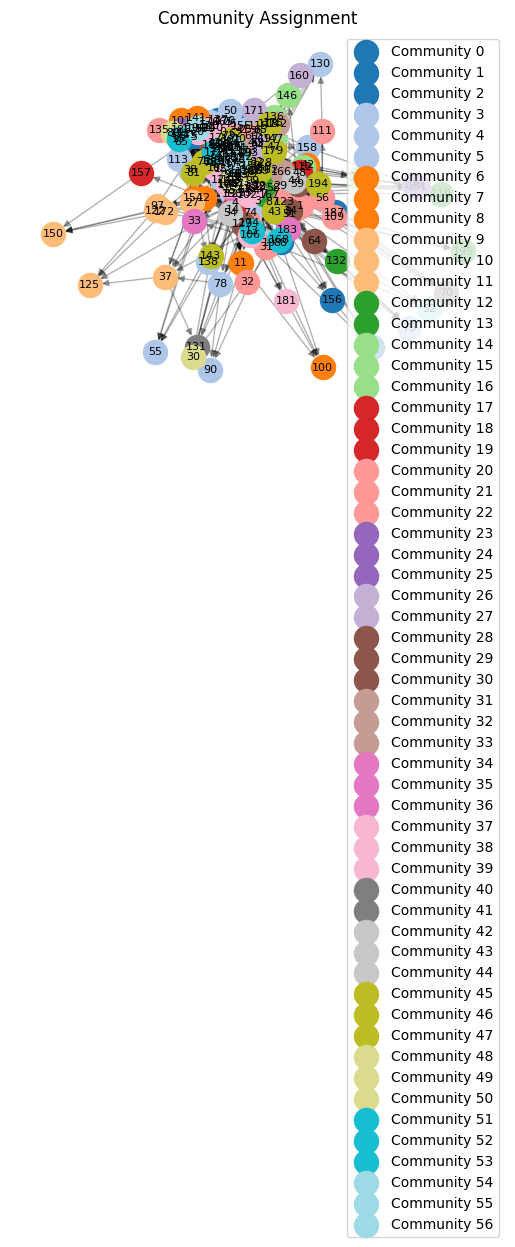

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import numpy as np

def plot_communities(G, labels):
    pos = nx.spring_layout(G, seed=42)
    communities = list(set(labels.values()))
    color_map = cm.get_cmap('tab20', len(communities))

    for idx, c in enumerate(communities):
        nodes = [n for n in G.nodes if labels[n] == c]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_color=[color_map(idx)],
            label=f'Community {c}'
        )

    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Community Assignment")
    plt.legend()
    plt.axis('off')
    plt.show()

labels, _ = frontier[23]
plot_communities(G_test, labels)

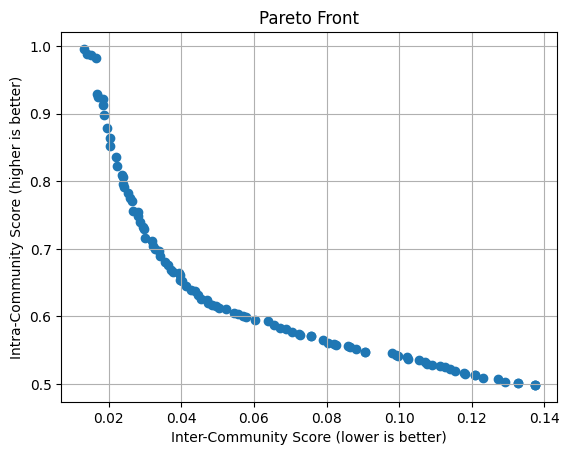

In [28]:
def plot_pareto_front(frontier):
  intra = [entry[1][0] for entry in frontier]
  inter = [entry[1][1] for entry in frontier]

  plt.figure()
  plt.scatter(inter, intra, marker='o')
  plt.xlabel("Inter-Community Score (lower is better)")
  plt.ylabel("Intra-Community Score (higher is better)")
  plt.title("Pareto Front")
  plt.grid(True)
  plt.show()

plot_pareto_front(frontier)
